# Assignment 11-part1: Neural Networks and PyTorch

This assignment is the continuation of the last week assignment and includes implementation of packpropagation from scratch, and also implementation of feedforward neural networks in PyTorch.



Only use the already imported library `numpy` and the Python standard library. For the evaluation you may also use scikit-learn (`sklearn`) and `matplotlib`. Make sure that the dataset `airfoil_self_noise.csv` is in the same directory as the notebook.

List your team members (name and immatriculation number) and indicate whether you are a B.Sc. Data Science or other group in the following cell:

- *Your names here*

In [ ]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np

def load_dataset(path):
    from sklearn.model_selection import train_test_split

    data = np.genfromtxt(path)
    X, y = data[:, :5], data[:, 5]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = load_dataset('airfoil_self_noise.csv')

## Task 3: Implementing a Feedforward Neural Network

In this task, you will implement a feedforward neural network for regression. The hyperparameters of the model are:
- `input_dim`: The dimension of the input vector.
- `output_dim`: The dimension of the output vector.
- `width`: The dimension of each hidden layer.
- `depth`: The number of hidden layers. For B.Sc. Data Science students, this parameter is constant with a value of 1.
- `learning_rate`: The learning rate for gradient descent.
- `epochs`: The number of epochs/iterations performed during training.

B.Sc. Data Science only have to implement for a single hidden layer, i.e. `depth = 1`. All other students have to implement the network for any `depth >= 1`.

The activation function for each hidden layer is ReLU ($g(x) = max(0, x)$). The output layer uses the identity as activation, since our objective is regression.

You have to implement the `FeedforwardNeuralNetworkRegressor`.

The `__init__` method initializes the network.
Initialize each weight and bias randomly with a standard Gaussian distribution using the numpy function `numpy.random.normal` with default parameters.

The `fit` method trains the network.
Use backpropagation with gradient descent similar to Task 2.
Use the whole training data set for each training epoch.
Use the mean squared error as loss function.

The `predict` method computes the forward-pass of the network.

We have provided code for preprocessing and validating your model.

In [ ]:
class FeedforwardNeuralNetworkRegressor(object):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        depth: int,
        learning_rate: float,
        epochs: int
    ):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.depth = depth
        self.learning_rate = learning_rate
        self.epochs = epochs
        # Create list for all weights and biases
        # Create a randomly initizalized weight and bias matrix for the input layer
        self.weights = [np.random.normal(size=(input_dim, hidden_dims[0]))]
        self.biases = [np.random.normal(size=(hidden_dims[0]))]
        # Create a randomly initizalized weight and bias matrix for each hidden layer
        for i in range(self.depth-1):
            self.weights.append(np.random.normal(size=(hidden_dims[i], hidden_dims[i+1])))
            self.biases.append(np.random.normal(size=(hidden_dims[i+1])))
        # Create a randomly initizalized weight and bias matrix for the output layer
        self.weights.append(np.random.normal(size=(hidden_dims[depth-1], output_dim)))
        self.biases.append(np.random.normal(size=(output_dim)))

    def fit(self, X, y):
        errors = np.zeros(self.epochs)
        current_ep = self.epochs-1
        for ep in range(self.epochs):
            self.hidden_z, self.hidden_x, pred = self.forward(X)
            errors[ep] = self.mse_loss(pred, y)
            if ep > 0 and (errors[ep-1]-errors[ep]) < 1e-5:
                current_ep = ep
                break
            biases_der, weights_der = self.backward(pred, y)
            for i in range(self.depth+1):
                self.biases[i] -= self.learning_rate * biases_der[self.depth-i]
                self.weights[i] -= self.learning_rate * weights_der[self.depth-i]
        return errors[:current_ep+1]

    def predict(self, X):
        # Run the forward pass and return the predicted output
        _, _, pred = self.forward(X)
        return pred


    def relu(self, layer):
        return np.maximum(0, layer)

    def relu_der(self, layer):
        return 1*(layer > 0)

    def mse_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true)*(y_pred - y_true))

    def mse_loss_der(self, y_pred, y_true):
        return 2 * (y_pred - y_true)

    def forward(self, X):
        # Implementation of the forward pass
        # Store the intermediate results of the hidden layers for the back propagation
        hidden_x = [X]
        hidden_z = []
        for i in range(self.depth):
            hidden_z.append(hidden_x[i] @ self.weights[i] + self.biases[i])
            hidden_x.append(self.relu(hidden_z[i]))
        output = hidden_x[self.depth] @ self.weights[self.depth] + self.biases[self.depth]

        return hidden_z, hidden_x, output

    def backward(self, pred, y):
        # delta = intermediate loss derivatives
        delta = self.mse_loss_der(pred, y)
        biases_der = [np.mean(delta, axis=0)]
        weights_der = [(self.hidden_x[self.depth].T @ delta)/len(delta)]
        for i in range(self.depth, 0, -1):
            delta = delta @ self.weights[i].T
            relu_der_z = self.relu_der(self.hidden_z[i-1])
            delta = np.multiply(delta, relu_der_z)
            biases_der.append(np.mean(delta, axis=0))
            weights_der.append((self.hidden_x[i-1].T @ delta)/len(delta))

        return biases_der, weights_der


In [ ]:
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

def normalizeData(data, minData, maxData):
    return (data - minData)/(maxData - minData)

Xmin = X_train.min(axis=0)
Xmax = X_train.max(axis=0)
Ymin = y_train.min(axis=0)
Ymax = y_train.max(axis=0)

X_train = normalizeData(X_train, Xmin, Xmax)
X_test = normalizeData(X_test, Xmin, Xmax)
y_train = normalizeData(y_train, Ymin, Ymax)
y_test = normalizeData(y_test, Ymin, Ymax)

Final training error ( Epoch 100 ): 0.04541136208751341
Test error: 0.04102164805488345


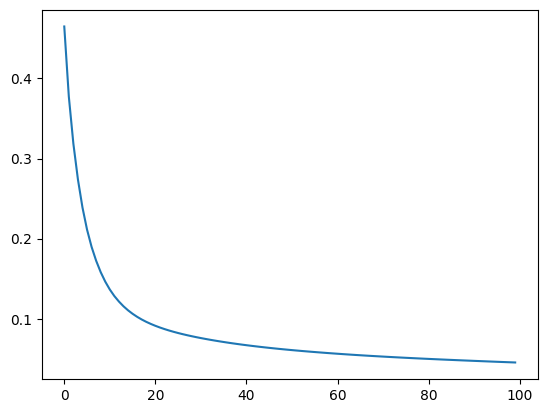

In [ ]:
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true)*(y_pred - y_true))


np.random.seed(2023)

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
nn = FeedforwardNeuralNetworkRegressor(input_dim, output_dim, [5], 1, 0.1, 100)
train_error = nn.fit(X_train, y_train)
print("Final training error ( Epoch", len(train_error), "):", train_error[len(train_error)-1])

y_pred = nn.predict(X_test)
test_error = mse_loss(y_pred, y_test)
print("Test error:", test_error)

plt.figure()
plt.plot(train_error)
plt.show()

## PyTorch:
In this part of the assignment, you will implement deep learning at the example of classification and regression tasks with PyTorch.
You are free to use any packages from the standard library and third-party libraries. However, to solve the assignment you will only need numpy, matplotlib, torch, and torchvision.

The following are covered in the rest of this assignment:


1.   Installation
2.   Tensor
3.   Autograd
4.   Building a model
5.   Training models


## Installation

Go to [PyTorch/Get Started](https://pytorch.org/get-started/locally/) to find installation instructions for torch and torchvisio for your specific hardware, operating system, and Python environment. If you are unsure about your hardware, select CPU as Compute Platform.

For example, installing for Windows via pip on CPU requires the following command:
```shell
pip3 install torch torchvision torchaudio
```

You might need to adjust some code in the following tasks, if you want to run it on a GPU.



At the first step, torch and its neural networks module, i.e., torch.nn should be imported.

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np

# Tensors

Torch operates on `torch.Tensors`. These tensors are very similar to Numpy's n-dimensional arrays. Most operations you know from numpy, such as slicing, arithmetics, etc. work similarly with tensors. Note that you have to use the torch equivalents of methods such as sum and mean, since Torch can only support autodifferentiation with such methods. Arithmetic operations between tensors  and slicing automatically support autodifferentiation.

Here there are a few basic tensor manipulations.

In [ ]:
x = torch.tensor([[1, 4], [2,3]])
print('x = ', x)
print('type =' , x.dtype)

x = x.to(torch.float32)

print('\n x = ', x)
print('type =' , x.dtype)

y = torch.tensor([[1.0, 4.0], [2.0, 3.0]])

print('\n y = ', y)
print('type =' , y.dtype)

# Tensor with random values

z = torch.rand(2, 2)
print('\n A random tensor:')
print(z)

# Basic arithmatic operations
k1 = y + x
k2 = y * x
k3 = y @ x

print('\n Addition and Multiplication:')
print(k1, '\n', k2, '\n', k3)

x =  tensor([[1, 4],
        [2, 3]])
type = torch.int64

 x =  tensor([[1., 4.],
        [2., 3.]])
type = torch.float32

 y =  tensor([[1., 4.],
        [2., 3.]])
type = torch.float32

 A random tensor:
tensor([[0.7225, 0.6426],
        [0.9107, 0.6178]])

 Addition and Multiplication:
tensor([[2., 8.],
        [4., 6.]]) 
 tensor([[ 1., 16.],
        [ 4.,  9.]]) 
 tensor([[ 9., 16.],
        [ 8., 17.]])


# Autograd:
PyTorch includes automated differentiation engine. To allow differantionation of a function f(w) w.r.t. the tensor w, the tensor should have "requires_grad= True", e.g., w = torch.tensor([[0.2, 0.4],[0.8, 0.1],[2.0, 0.5]], requires_grad= True). You can access the gradient by w.grad.

##Task 4: Implementation of simple Feedforward Neural Network in Pytorch:

In the "Neural Networks Example" task described in the PDF file, you manually performed the forward pass and gradient calculation. Now, in this new task, you will implement the same task but using tensors and PyTorch's autograd functionality. Once you compute the loss, you can use the loss.backward() function to perform backpropagation. Your goal is to compare the results of the forward pass, loss calculation, backpropagation, and parameter updates between these two approaches (manual gradient computation v.s. automated gradient computation).

In [ ]:
wh = torch.tensor([[0.2, 0.4],[0.8, 0.1],[2.0, 0.5]], requires_grad= True)
print(wh.shape)
bh = torch.tensor([1.0, 1.0, -4.0], requires_grad= True).unsqueeze(1)
print(bh.shape)

wo = torch.tensor([0.5, -1.0, 0.0], requires_grad= True).unsqueeze(0)
print(wo.shape)
bo = torch.tensor([3.0], requires_grad= True)

x = torch.tensor([1.0, 2.0]).unsqueeze(1)
print(x.shape)

z = wh @ x + bh

print(z.shape)
print(z)

h = torch.relu(z)
print(h)
print(h.requires_grad)

yhat = wo @ h + bo
print(yhat.shape, yhat)
y = -1

loss = torch.log(1 + torch.exp((1 - 2*y)* yhat))
print(loss)

lr = 0.1
print(wh.grad)
loss.backward()
print(wh.grad)

wh = wh - 0.1 * wh.grad
print(wh)

torch.Size([3, 2])
torch.Size([3, 1])
torch.Size([1, 3])
torch.Size([2, 1])
torch.Size([3, 1])
tensor([[ 2.],
        [ 2.],
        [-1.]], grad_fn=<AddBackward0>)
tensor([[2.],
        [2.],
        [0.]], grad_fn=<ReluBackward0>)
True
torch.Size([1, 1]) tensor([[2.]], grad_fn=<AddBackward0>)
tensor([[6.0025]], grad_fn=<LogBackward0>)
None
tensor([[ 1.4963,  2.9926],
        [-2.9926, -5.9852],
        [ 0.0000,  0.0000]])
tensor([[0.0504, 0.1007],
        [1.0993, 0.6985],
        [2.0000, 0.5000]], grad_fn=<SubBackward0>)


# Building a model:

PyTorch provided various building blocks of Neural Neuworks such as linear model, various activation functions (relu, tanh, etc), convolution layer, etc.    
## Modules

Modules are the second key component of Torch after tensors. Modules represent network layers, loss functions, and entire neural networks. Torch offers a large library of modules, which you can overview [here](https://pytorch.org/docs/stable/nn.html).

A [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) can be easily implemented by inherting from `nn.Module` and implementing at least the `forward` method, which defines the computation your network makes during the forward pass. Due to Torch's autodifferentiation, the backward pass (including gradient computation) is performed automatically by Torch.

The following cell implements an example Module for a simple linear model with quadratic features.

In [ ]:
linear = nn.Linear(2,3) #w x + b

print("Initial weights:")
print(linear.weight)
print("\nInitial biases:")
print(linear.bias)

linear.bias = nn.Parameter(torch.tensor([1.0,2.0,3.0]))
print("\n Biases after setting:")
print(linear.bias)

h1 = linear(x.t())
print(h1)


Initial weights:
Parameter containing:
tensor([[ 0.4849,  0.5148],
        [ 0.4930, -0.6049],
        [ 0.4167, -0.6121]], requires_grad=True)

Initial biases:
Parameter containing:
tensor([ 0.4145, -0.2732, -0.0903], requires_grad=True)

 Biases after setting:
Parameter containing:
tensor([1., 2., 3.], requires_grad=True)
tensor([[2.5145, 1.2832, 2.1924]], grad_fn=<AddmmBackward0>)


##Task 5: Build a simple model in PyTorch:

In task 4, you implemented a simple neural network (introduced in pdf, part "neural network example") by using tensor. In this task, you will implement the neural network of task 4 by using torch.nn.Linear and asnwer the same questions given in task "Neural Network example" in pdf file, and compare the results.

In [ ]:
import torch.optim as optim
class SimpleNN(nn.Module):

    def __init__(self):
        super(SimpleNN, self).__init__()
        # NN with one hidden layer (with 3 hidden nodes), and one output node
        # The input data is 2 dimensional

        self.linear_h = nn.Linear(2,3)
        self.linear_out = nn.Linear(3,1)
        self.relu = nn.ReLU()


        self.linear_h.weight.data = torch.tensor([[0.2, 0.4],[0.8, 0.1],[2.0, 0.5]])
        self.linear_h.bias.data = torch.tensor([1.0, 1.0, -4.0])

        self.linear_out.weight.data = torch.tensor([0.5, -1.0, 0.0])
        self.linear_out.bias.data = torch.tensor(3.0)

    def forward(self, x):
        print('forward', x.shape)
        out = torch.relu(self.linear_h(x))
        out2 = self.linear_out(out)
        return out2

x = torch.tensor([1.0, 2.0])
neural_net = SimpleNN()
yhat = neural_net.forward(x)
y = -1
print('yhat = ', yhat)
loss_fn = nn.Softplus()
loss = loss_fn((1-2*y)*yhat)
print('loss = ', loss)

optimizer = optim.SGD(neural_net.parameters(), lr=0.1)
optimizer.zero_grad()

loss.backward()
optimizer.step()

print(neural_net.linear_h.weight.data)
print(neural_net.linear_h.weight.grad)

forward torch.Size([2])
yhat =  tensor(2., grad_fn=<AddBackward0>)
loss =  tensor(6.0025, grad_fn=<SoftplusBackward0>)
tensor([[0.0504, 0.1007],
        [1.0993, 0.6985],
        [2.0000, 0.5000]])
tensor([[ 1.4963,  2.9926],
        [-2.9926, -5.9852],
        [ 0.0000,  0.0000]])


## Task 6: Implementing a Feedforward Neural Network with PyTorch

Implement the neural network in task 3 with PyTorch

In [ ]:
class FeedforwardNeuralNetworkRegressorPytorch(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        depth: int,
        learning_rate: float,
        epochs: int
    ):
        super(FeedforwardNeuralNetworkRegressorPytorch, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.depth = depth
        self.learning_rate = learning_rate
        self.epochs = epochs
        # Create list for all weights and biases
        # Create a randomly initizalized weight and bias matrix for the input layer
        layer_sizes = [input_dim] + hidden_dims + [output_dim]
        layers = []

        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)


    def forward(self, x):
        return self.network(x)


Epoch [100/1000], Loss: 0.3498
Epoch [200/1000], Loss: 0.3498
Epoch [300/1000], Loss: 0.3498
Epoch [400/1000], Loss: 0.3498
Epoch [500/1000], Loss: 0.3498
Epoch [600/1000], Loss: 0.3498
Epoch [700/1000], Loss: 0.3498
Epoch [800/1000], Loss: 0.3498
Epoch [900/1000], Loss: 0.3498
Epoch [1000/1000], Loss: 0.3498
Test error: tensor(0.3526, grad_fn=<MseLossBackward0>)


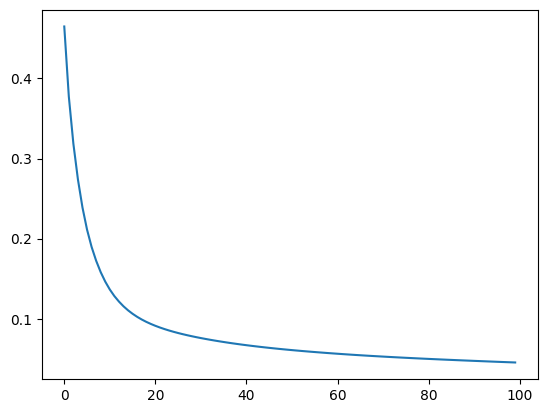

In [ ]:
np.random.seed(2023)

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = FeedforwardNeuralNetworkRegressorPytorch(input_dim, output_dim, [5], 1, 0.1, 100)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(torch.from_numpy(X_train).to(torch.float32))
    loss = criterion(outputs, torch.from_numpy(y_train).to(torch.float32))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

y_pred = model(torch.from_numpy(X_test).to(torch.float32))
ytest = torch.from_numpy(y_test).to(torch.float32)
test_error = criterion(y_pred, ytest)
print("Test error:", test_error)

plt.figure()
plt.plot(train_error)
plt.show()